In [ ]:
!pip install graphlearning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.2/77.2 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for graphlearning: filename=graphlearning-1.4.8-cp310-cp310-linux_x86_64.whl size=160210 sha256=2d232c57bc8791e54ab067321c5043b5b7f5f1fc18e7f81943a7a63de856760c
  Stored in directory: /root/.cache/pip/wheels/93/c6/8d/4a578464d1e49ca78b7d86e33999fc57e32e53583e5e327bb3
Successfully built graphlearning


In [ ]:
import numpy as np
import scipy.integrate as integrate
from scipy.optimize import fsolve
import scipy
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn import datasets
import scipy.misc

import graphlearning as gl

import matplotlib.pyplot as plt

In [ ]:
def noisyscurve(samples, noise, seed):
    s_pts, s_color = datasets.make_s_curve(n_samples=samples, noise=noise, random_state=seed)
    labels = np.concatenate([s_color[:, np.newaxis], s_pts[:,[1]]], axis=1)
    return s_pts, s_color, labels

In [ ]:
def noisyswissroll(RES=100, noise=0.00, noise_type = 'normal'):
    """swiss roll on a grid """
    theta0 = 3*np.pi/2
    nturns = 2
    rmax = 2*1e-2
    sideL1 = integrate.quad(lambda x: rmax*np.sqrt(1+x**2), theta0, theta0*(1+nturns))[0]
    sideL2 = 1/sideL1
    RESt = int(np.ceil(sideL1*RES+1))
    tdistv = np.linspace(0,sideL1,RESt)
    tv = []
    for tdist in tdistv.tolist():
        tt = fsolve(lambda x: (0.5*rmax*(x*np.sqrt(1+x**2)+np.arcsinh(x)))-\
                                0.5*rmax*(theta0*np.sqrt(1+theta0**2)+np.arcsinh(theta0))-\
                                tdist,theta0*(1+nturns/2))
        tv.append(tt)
    tv = np.array(tv)
    RESh = int(np.ceil(sideL2*RES+1))
    heightv = np.linspace(0,sideL2,RESh)[:,np.newaxis]
    heightv = np.tile(heightv,[RESt,1])
    heightv = heightv.flatten('F')[:,np.newaxis]
    tv = np.repeat(tv,RESh)[:,np.newaxis]
    X=np.concatenate([rmax*tv*np.cos(tv), heightv, rmax*tv*np.sin(tv)], axis=1)
    np.random.seed(42)
    if noise_type == 'normal':
        X = X+noise*np.random.normal(0,1,[X.shape[0],3])
    elif noise_type == 'uniform':
        X = X+noise*np.random.uniform(0,1,[X.shape[0],3])
    labelsMat = np.concatenate([tv, X[:,[1]]], axis=1)
    print('X.shape = ', X.shape)
    return X, labelsMat, tv

[-1.18243152  4.24788226  2.18649139 ...  4.39239426  2.46022321
  4.24843268]
[-1.18243152  4.24788226  2.18649139 ...  4.39239426  2.46022321
  4.24843268]


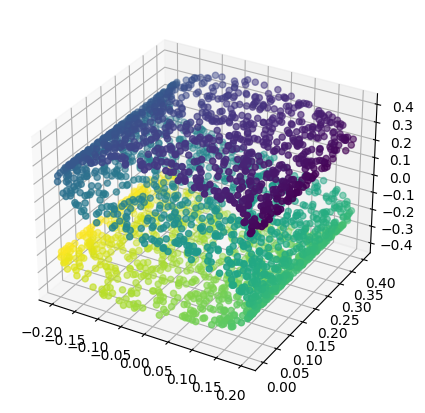

In [ ]:
"""s curve observations"""
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')

s_pts, s_color, labels = noisyscurve(2639, 0.00, 42)

print(labels[:,0])
print(s_color)

ax.scatter(s_pts[:, 0]/5, s_pts[:, 1]/5, s_pts[:,2]/5, c=s_color/5)

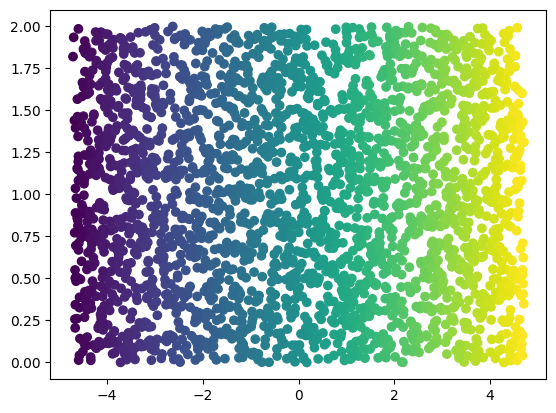

In [ ]:
""" s curve gorund truth """
plt.scatter(labels[:, 0], labels[:, 1], c=s_color)

[[-1.73130362e-17  0.00000000e+00 -9.42477796e-02]
 [-1.73130362e-17  1.99804057e-02 -9.42477796e-02]
 [-1.73130362e-17  3.99608114e-02 -9.42477796e-02]
 ...
 [ 1.47211562e-14  5.19490548e-01  2.82743339e-01]
 [ 1.47211562e-14  5.39470953e-01  2.82743339e-01]
 [ 1.47211562e-14  5.59451359e-01  2.82743339e-01]]
[[0.        ]
 [0.01998041]
 [0.03996081]
 ...
 [0.51949055]
 [0.53947095]
 [0.55945136]]


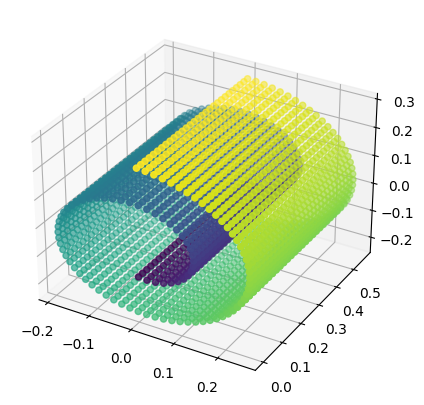

In [ ]:
"""swiss roll observations """
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')

ax.scatter(X[:,0], X[:,1], X[:,2], c=tv)
plt.show()

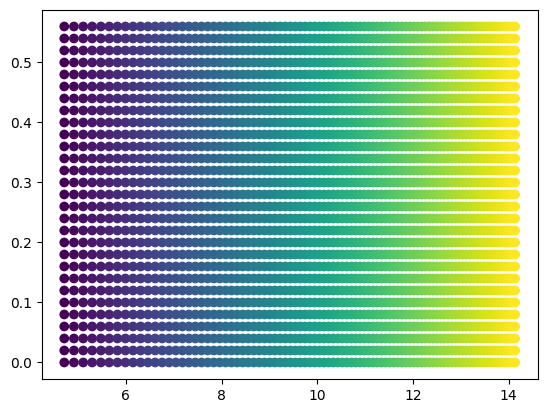

In [ ]:
"""swiss roll ground truth """
plt.scatter(labels[:,0], labels[:,1], c=tv)

In [ ]:
labels.shape

(2639, 2)

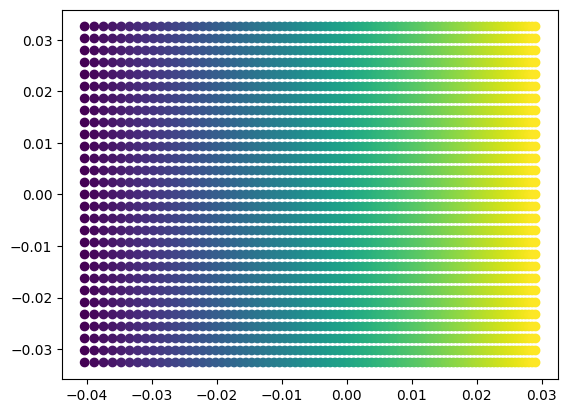

In [ ]:
l = labels - labels.mean(0)
l = l / np.linalg.norm(l,axis=0, keepdims=True)
plt.scatter(l[:,0], l[:,1], c=tv)

Text(0.5, 1.0, 'LLE Embedding of Swiss Roll Error: 0.14')

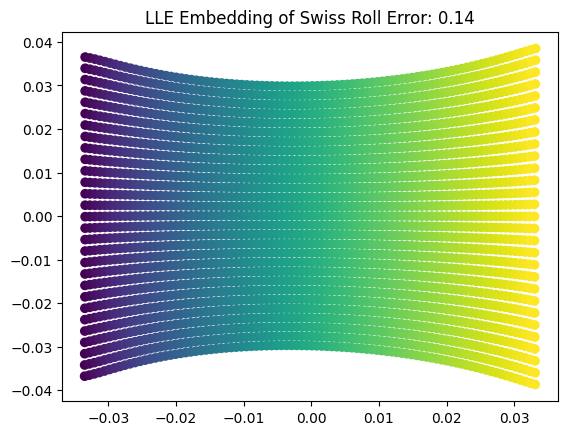

In [ ]:
"""sklearn tsne """
sr_lle, sr_err = manifold.locally_linear_embedding(X, n_neighbors=12, n_components=2)

plt.scatter(sr_lle[:, 0], sr_lle[:, 1], c=tv)
plt.title(f"LLE Embedding of Swiss Roll Error: {np.linalg.norm(l - sr_lle):.2f}")

Text(0.5, 1.0, 'Spectral Embedding of Swiss Roll: 1.38')

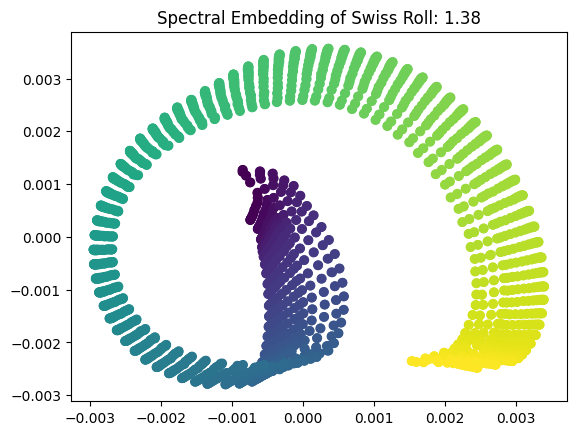

In [ ]:
"""sklearn spectral embedding (takes a long time) """
embedding = manifold.SpectralEmbedding(n_components=2, n_neighbors=100)
sr_se = embedding.fit_transform(X)

plt.scatter(sr_se[:, 0], sr_se[:, 1], c=tv)
plt.title(f"Spectral Embedding of Swiss Roll: {np.linalg.norm(l - sr_se):.2f}")


In [ ]:
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import NearestNeighbors


# includes self as the first neighbor
# data is either X or distance matrix d_e
def nearest_neighbors(data, k_nn, metric, n_jobs=-1, sort_results=True):
    n = data.shape[0]
    if k_nn > 1:
        neigh = NearestNeighbors(n_neighbors=k_nn-1, metric=metric, n_jobs=n_jobs)
        neigh.fit(data)
        neigh_dist, neigh_ind = neigh.kneighbors()
        neigh_dist = np.insert(neigh_dist, 0, np.zeros(n), axis=1)
        neigh_ind = np.insert(neigh_ind, 0, np.arange(n), axis=1)
        if sort_results:
            inds = np.argsort(neigh_dist, axis=-1)
            for i in range(neigh_ind.shape[0]):
                neigh_ind[i,:] = neigh_ind[i,inds[i,:]]
                neigh_dist[i,:] = neigh_dist[i,inds[i,:]]
    else:
        neigh_dist = np.zeros((n,1))
        neigh_ind = np.arange(n).reshape((n,1)).astype('int')
    return neigh_dist, neigh_ind

In [ ]:
# uniformly randomly sample points to label
m = 250
m2 = n - m

train_ind = np.random.choice(n, m, replace=False)
train_ind = np.sort(train_ind)
X1 = train_labels = l[train_ind]

r = 2
om = np.ones((m,1))
om2 = np.ones((m2,1))
c1 = -X1.T@om
P = np.eye(m2) - 1/m2*np.ones((m2,m2))
C = np.eye(r) - X1.T@X1 - 1/m2 * (c1@c1.T)

In [ ]:
from scipy.sparse import coo_matrix

In [ ]:
"""semi-supervised procrustes """
idx = np.ones(n, dtype=bool)
idx[train_ind] = False

k_nn = 56
h = 0.1
W = gl.weightmatrix.knn(X, k=k_nn, kernel='distance')
W.data = np.exp(-W.data**2/h**2)
W = 1/2 * W + W.T

G = gl.graph(W)
L = G.laplacian(normalization='combinatorial')

Ltilde = L[idx][:, idx]
B = P@(1/m2 * L[idx][:,idx]@om2@c1.T +  L[idx][:,train_ind]@X1)
PLtildeP = P@Ltilde@P

eigenValues, eigenVectors = np.linalg.eigh(PLtildeP)

s = eigenValues.argsort()
vals = eigenValues[s]
vecs = eigenVectors[:,s]

In [ ]:
# calculate Q transform from prop
Csqrt = scipy.linalg.sqrtm(C)
XtB = vecs.T@B
U, s, Vh = np.linalg.svd(XtB, full_matrices=False)
Q = -U@Vh
vecs = vecs@Q

e = vecs@Csqrt + 1/m2 * om2@c1.T

emb = np.zeros((n,2))
emb[idx] = e
emb[~idx] = X1

Text(0.5, 1.0, 'Procrustes Embedding of Swiss Roll Error: 0.49')

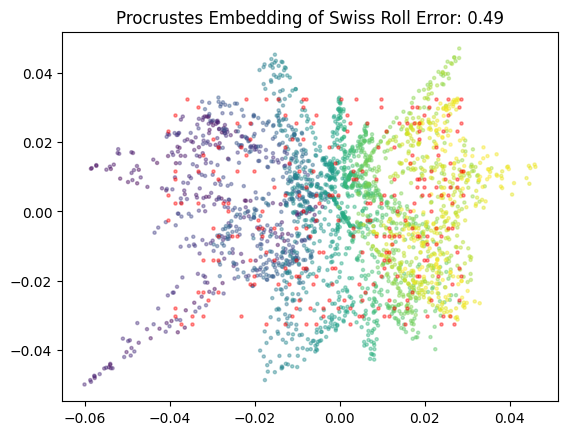

In [ ]:
plt.scatter(emb[idx, 0], emb[idx, 1], c=tv[idx], alpha=0.4, s=5)
plt.scatter(emb[train_ind, 0], emb[train_ind, 1], c='red', alpha=0.4, s=5)
plt.title(f"Procrustes Embedding of Swiss Roll Error: {np.linalg.norm(l - emb):.2f}")

In [ ]:
import jax
from jax import numpy as jnp
from jax import jit, vmap

from jax import config
config.update("jax_enable_x64", True)

In [ ]:
"""projected gradient method """

def _sqrtm(C):
    # Computing diagonalization
    evalues, evectors = jnp.linalg.eig(C)
    # Ensuring square root matrix exists
    sqrt_matrix = evectors @ jnp.diag(jnp.sqrt(evalues)) @ jnp.linalg.inv(evectors)
    return sqrt_matrix.real

def nonzero_sorted_eig(A, eps=1e-5):
    w,v = jnp.linalg.eig(A)
    w = w.at[w < eps].set(0)
    sidx = jnp.argsort(w)
    idx = sidx[jnp.in1d(sidx, jnp.flatnonzero(w!=0))]
    return w[idx].real, v[:,idx].real


def stproject(x):
  U_x, _, V_xt = jnp.linalg.svd(x, full_matrices=False)
  return U_x@V_xt

# Geometric progression: step sizes for line search
beta=0.9
step_sizes = 1*jnp.power(beta,jnp.linspace(0,100,num=100))

step_sizes = jnp.append(step_sizes,0)
step_sizes=np.array(step_sizes)

In [ ]:
def F(X, A, B, C):
  """Lagrangian - 116 """
  C_sqrt = _sqrtm(C).real
  return  jnp.trace(jnp.dot(X.T, A@X@C)) - 2*jnp.trace(jnp.dot(X.T, B@C_sqrt))

def _value_and_gradF(X, A, B, C):
  """grad F """
  C_sqrt = _sqrtm(C).real
  return F(X, A, B, C), A@X@C - B@C_sqrt

In [ ]:
def _line_search(s, Gk, Xk, L_, B_, C):
  Xk = stproject(Xk - s*Gk)
  _f_k = F(Xk, L_, B_, C)
  return _f_k, Xk

In [ ]:
Xk = jnp.array(vecs)
for k in range(100):
  Fk, Gk = _value_and_gradF(Xk, PLtildeP, B, C)

  _Fks, _Xks = vmap(_line_search,in_axes=(0,None,None,None,None,None))(step_sizes,Gk,Xk,PLtildeP,B,C)

  _f_kamin = jnp.argmin(_Fks)
  _f_k = _Fks[_f_kamin]
  Xk = _Xks[_f_kamin]

  if k % 10 == 0:
    print(Fk)

39.63344355018725
-8.135199645640476
-8.162074139150466
-8.163236106158802
-8.1633319762045
-8.163338693334895
-8.163339049579587
-8.163339071370183
-8.16333907193842
-8.163339071990979


In [ ]:
e = Xk@Csqrt + 1/m2 * om2@c1.T

emb = np.zeros((n,2))
emb[idx] = e
emb[~idx] = X1

Text(0.5, 1.0, 'Gradient Projection Embedding of Swiss Roll Error: 2.69')

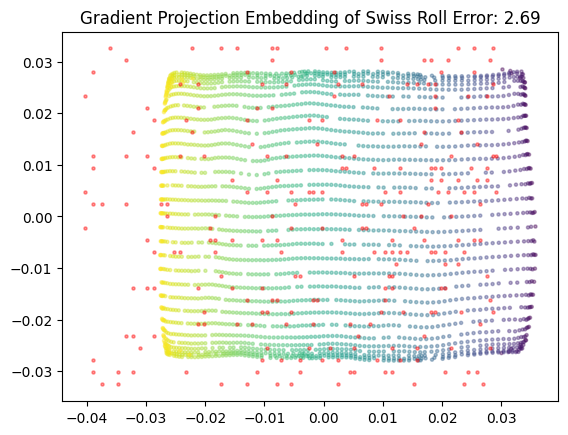

In [ ]:
plt.scatter(emb[idx, 0], emb[idx, 1], c=tv[idx], alpha=0.4, s=5)
plt.scatter(emb[train_ind, 0], emb[train_ind, 1], c='red', alpha=0.4, s=5)
plt.title(f"Gradient Projection Embedding of Swiss Roll Error: {np.linalg.norm(l - emb):.2f}")